In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
%matplotlib inline

### Load dataset

* Reference: https://archive.ics.uci.edu/dataset/109/wine
    * Most features in the Wine UCI dataset are continuous, so they are appropriate for regression.
    * No categorical features, so we don't need One-hot encoding

In [3]:
def load_dataset() -> (pd.DataFrame, pd.DataFrame):
    # From https://archive.ics.uci.edu/dataset/109/wine
    wine = fetch_ucirepo(id=109) 
    
    X = wine.data.features 
    y = wine.data.targets 

    print(f"===== X: {X.head()}")
    print(f"===== Y: {y.head()}")

    return X, y

In [4]:
X_all_features, y = load_dataset()

===== X:    Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  
0               

In [5]:
def create_dataset(X_all_features, y, x_feature, y_feature):
    # Keep only one feature
    X = X_all_features[x_feature].to_frame() # Kepp as a dataframe and not a series
    y = X_all_features[y_feature].to_frame()

    data = pd.DataFrame(columns = ['X','Y'])
    data.X = X
    data.Y = y

    return X, y, data

In [6]:
X, y, data = create_dataset(X_all_features, y, 'Alcohol', 'Color_intensity')

#### Visualize data in the dataset

In [7]:
def visualize_dataset(data):
    sns.set_palette('colorblind')
    sns.pairplot(data=data, height=3)

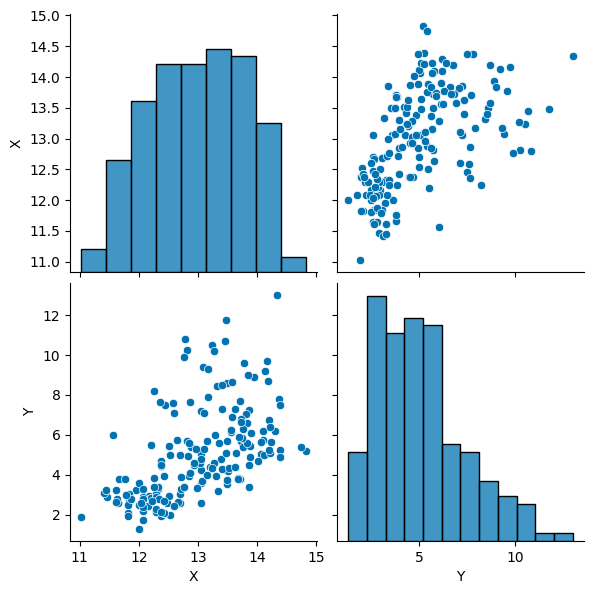

In [8]:
visualize_dataset(data)

### Apply linear regression

In [9]:
def apply_linear_regression(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    print(f"lr.coef_: {lr.coef_}")
    print(f"lr.intercept_: {lr.intercept_}")
    return lr

In [10]:
lr = apply_linear_regression(X, y)

lr.coef_: [[1.56022048]]
lr.intercept_: [-15.2257406]


### Ordinary Least Sqare (OLS) Stats Model

In [11]:
def ols_lr(X, y):
    dataset = sm.add_constant(X)
    model = sm.OLS(y, dataset)
    results = model.fit()
    print(f"results.params: {results.params}")
    print(f"results.summary: {results.summary()}")

    return results

In [12]:
results = ols_lr(X, y)

results.params: const     -15.225741
Alcohol     1.560220
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:        Color_intensity   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     74.90
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           3.06e-15
Time:                        14:08:40   Log-Likelihood:                -370.18
No. Observations:                 178   AIC:                             744.4
Df Residuals:                     176   BIC:                             750.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
def plot_lr(X, data, lr, x_feature, y_feature):
    ax = data.plot(kind='scatter', x='X', y='Y')
    ax.plot(X, lr.predict(X),'r', color="red")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

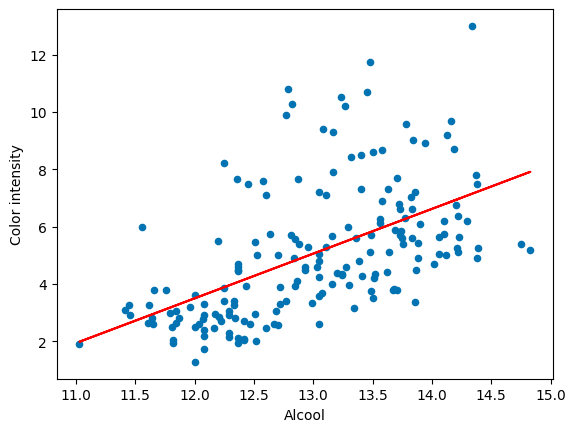

In [14]:
plot_lr(X, data, lr, "Alcool", "Color intensity")

#### Perform White's test to know whether there is heteroscedascity

In [15]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from patsy import dmatrices

In [16]:
def white_test(data, lr_results):
    expr = 'Y~ X'
    y, X = dmatrices(expr, data, return_type='dataframe')
    keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
    white_results = het_white(lr_results.resid, X)
    final_results = dict(zip(keys, white_results))
    print(final_results)
    return final_results


In [17]:
white_test(data, results)

{'Lagrange Multiplier statistic:': 5.391450827921087, "LM test's p-value:": 0.06749340335451966, 'F-statistic:': 2.733074055172031, "F-test's p-value:": 0.06779555802825442}


{'Lagrange Multiplier statistic:': 5.391450827921087,
 "LM test's p-value:": 0.06749340335451966,
 'F-statistic:': 2.733074055172031,
 "F-test's p-value:": 0.06779555802825442}

* Null Hypothesis: Homoscedascity is present.
* The p-value > 0.05, so we don't reject the null hypothesis, and confirm that there is no heteroscedascity.

##### Try another set of variables to check if there is Heteroscedascity

===== Feature: Malicacid
lr.coef_: [[0.12989865]]
lr.intercept_: [0.64758554]
results.params: const      0.647586
Alcohol    0.129899
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:              Malicacid   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.582
Date:                Wed, 10 Jan 2024   Prob (F-statistic):              0.210
Time:                        14:08:41   Log-Likelihood:                -270.99
No. Observations:                 178   AIC:                             546.0
Df Residuals:                     176   BIC:                             552.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t 

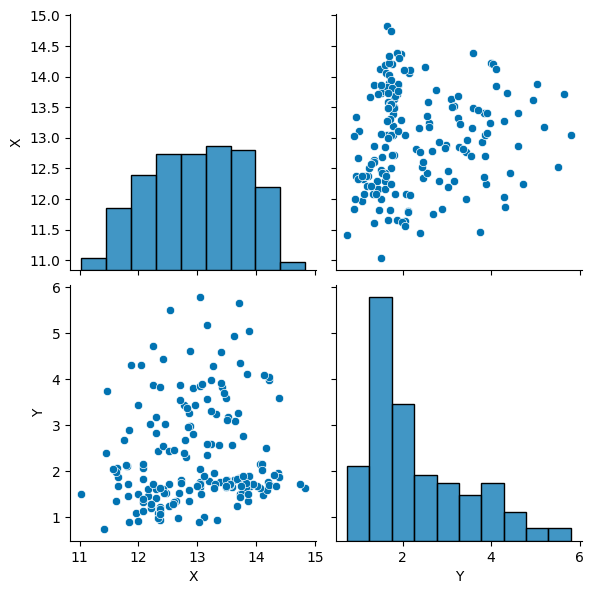

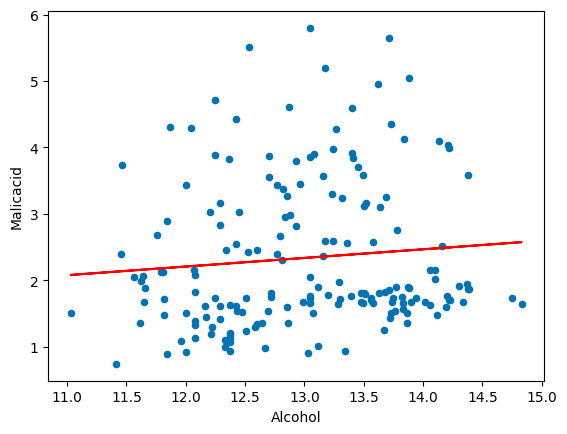

{'Lagrange Multiplier statistic:': 2.9963108302660366, "LM test's p-value:": 0.22354212249815655, 'F-statistic:': 1.4981238332295752, "F-test's p-value:": 0.22640193931166722}
Feature Malicacid makes regression model homoscedastic
===== Feature: Ash
lr.coef_: [[0.07148817]]
lr.intercept_: [1.43712648]
results.params: const      1.437126
Alcohol    0.071488
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:                    Ash   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     8.245
Date:                Wed, 10 Jan 2024   Prob (F-statistic):            0.00459
Time:                        14:08:43   Log-Likelihood:                -17.775
No. Observations:                 178   AIC:                             39.55
Df Residuals:                     176   BIC:            

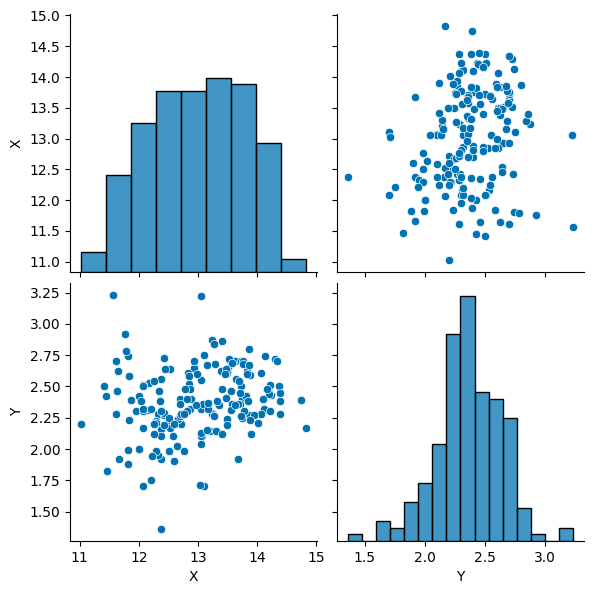

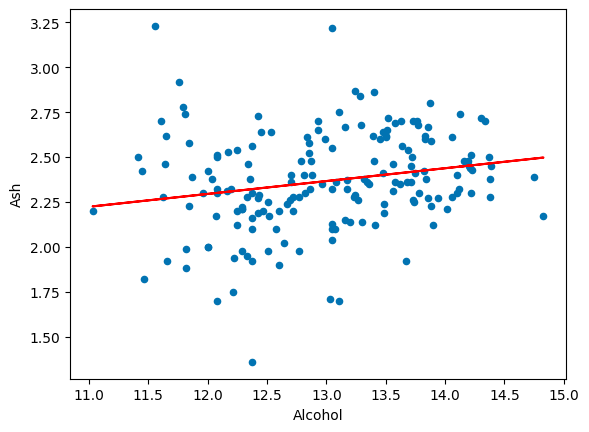

{'Lagrange Multiplier statistic:': 8.694639099088004, "LM test's p-value:": 0.012941455060130239, 'F-statistic:': 4.493543010817338, "F-test's p-value:": 0.012500774222760967}
Feature Ash makes regression model heteroscedastic
===== Feature: Alcalinity_of_ash
lr.coef_: [[-1.2761963]]
lr.intercept_: [36.08628436]
results.params: const      36.086284
Alcohol    -1.276196
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:      Alcalinity_of_ash   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     18.74
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           2.51e-05
Time:                        14:08:44   Log-Likelihood:                -457.70
No. Observations:                 178   AIC:                             919.4
Df Residuals:                     176   BIC

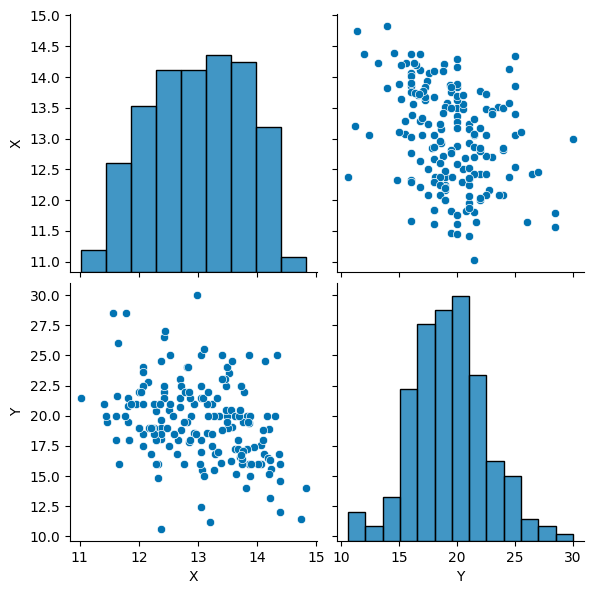

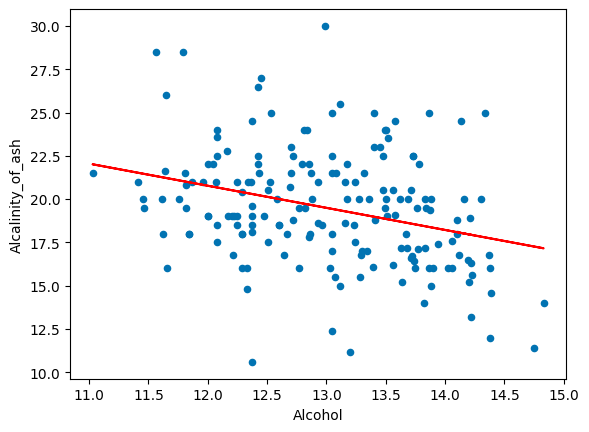

{'Lagrange Multiplier statistic:': 0.12316193234199702, "LM test's p-value:": 0.9402768120441934, 'F-statistic:': 0.06058500475382466, "F-test's p-value:": 0.9412334905893757}
Feature Alcalinity_of_ash makes regression model homoscedastic
===== Feature: Magnesium
lr.coef_: [[4.7641596]]
lr.intercept_: [37.80455404]
results.params: const      37.804554
Alcohol     4.764160
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:              Magnesium   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     13.93
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           0.000256
Time:                        14:08:45   Log-Likelihood:                -718.60
No. Observations:                 178   AIC:                             1441.
Df Residuals:                     176   

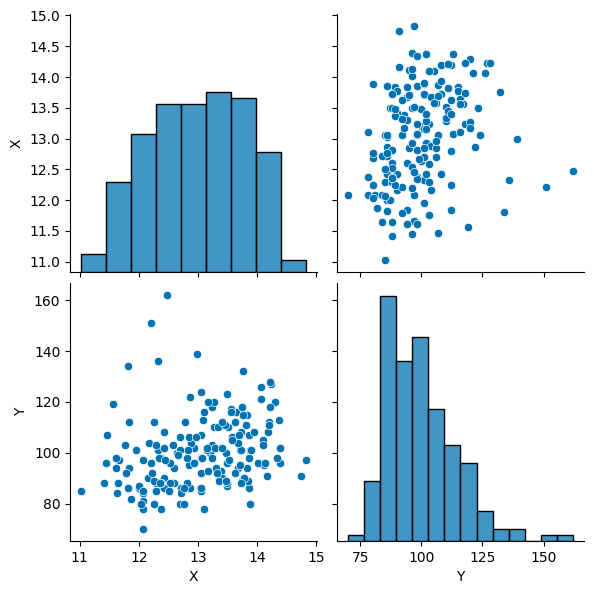

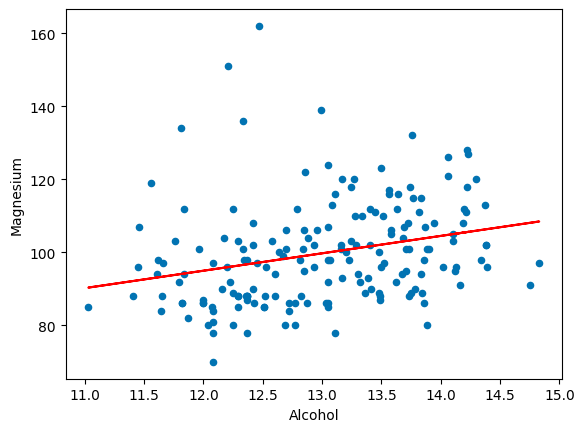

{'Lagrange Multiplier statistic:': 1.4394403744578237, "LM test's p-value:": 0.4868884745145018, 'F-statistic:': 0.7133588216540631, "F-test's p-value:": 0.491414830119995}
Feature Magnesium makes regression model homoscedastic
===== Feature: Total_phenols
lr.coef_: [[0.22287303]]
lr.intercept_: [-0.60237477]
results.params: const     -0.602375
Alcohol    0.222873
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:          Total_phenols   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     16.05
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           9.08e-05
Time:                        14:08:46   Log-Likelihood:                -160.88
No. Observations:                 178   AIC:                             325.8
Df Residuals:                     176   BIC:    

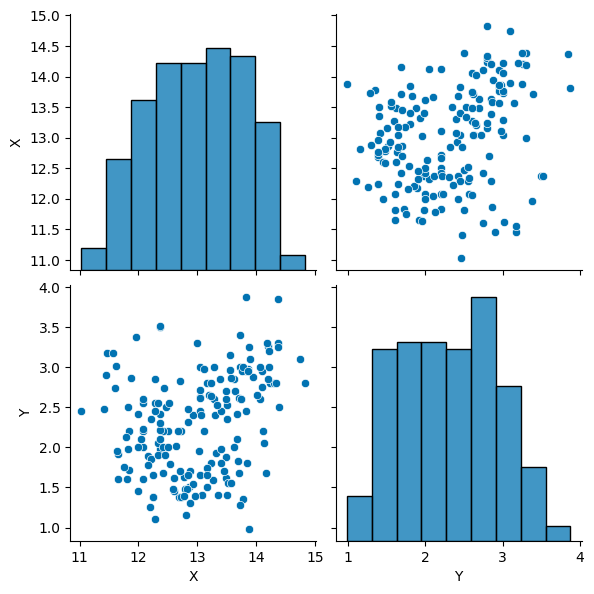

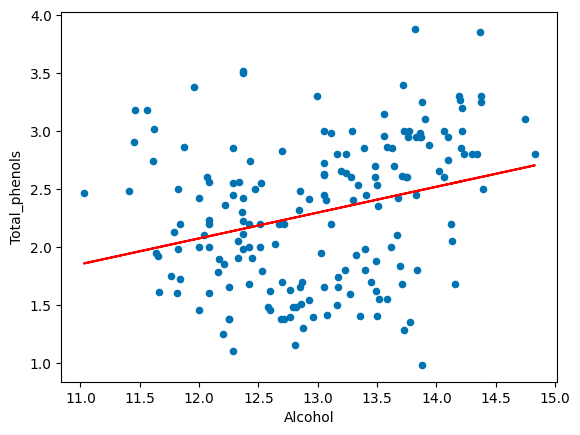

{'Lagrange Multiplier statistic:': 0.3289268351956596, "LM test's p-value:": 0.848348791013339, 'F-statistic:': 0.16199090581798442, "F-test's p-value:": 0.8505763148703734}
Feature Total_phenols makes regression model homoscedastic
===== Feature: Flavanoids
lr.coef_: [[0.29137339]]
lr.intercept_: [-1.75876442]
results.params: const     -1.758764
Alcohol    0.291373
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:             Flavanoids   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     10.46
Date:                Wed, 10 Jan 2024   Prob (F-statistic):            0.00146
Time:                        14:08:47   Log-Likelihood:                -246.73
No. Observations:                 178   AIC:                             497.5
Df Residuals:                     176   BIC:  

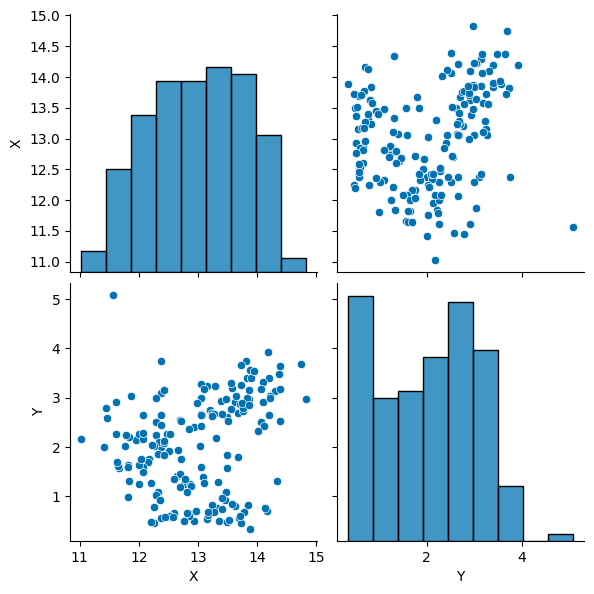

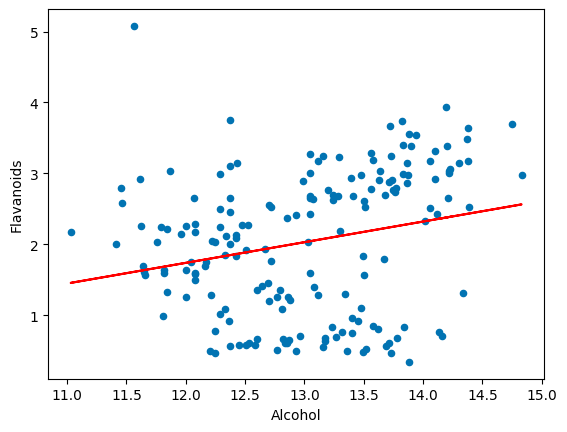

{'Lagrange Multiplier statistic:': 1.2625807849757575, "LM test's p-value:": 0.5319049917698135, 'F-statistic:': 0.6250844850855894, "F-test's p-value:": 0.5364068723679074}
Feature Flavanoids makes regression model homoscedastic
===== Feature: Nonflavanoid_phenols
lr.coef_: [[-0.02390405]]
lr.intercept_: [0.67262137]
results.params: const      0.672621
Alcohol   -0.023904
dtype: float64
results.summary:                              OLS Regression Results                             
Dep. Variable:     Nonflavanoid_phenols   R-squared:                       0.024
Model:                              OLS   Adj. R-squared:                  0.019
Method:                   Least Squares   F-statistic:                     4.386
Date:                  Wed, 10 Jan 2024   Prob (F-statistic):             0.0377
Time:                          14:08:48   Log-Likelihood:                 121.04
No. Observations:                   178   AIC:                            -238.1
Df Residuals:            

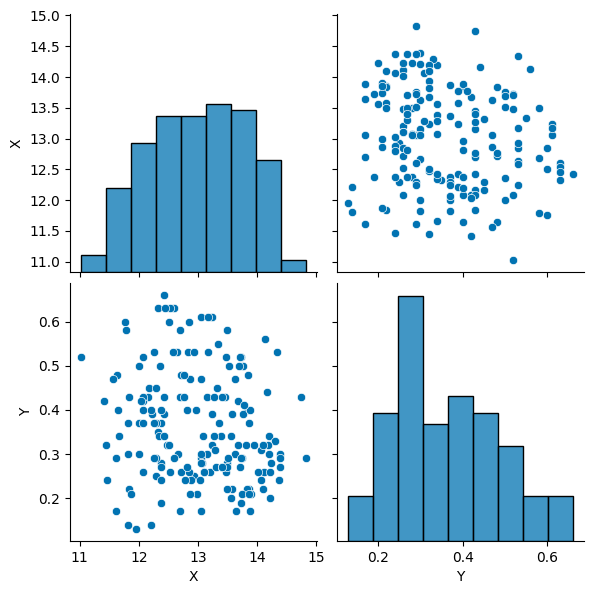

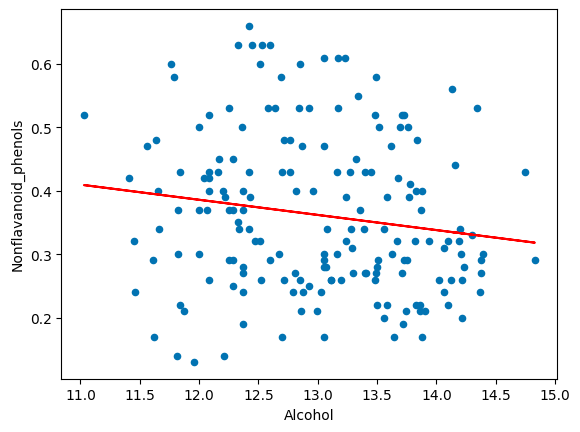

{'Lagrange Multiplier statistic:': 5.595625309705404, "LM test's p-value:": 0.060943220798959676, 'F-statistic:': 2.8399349812251953, "F-test's p-value:": 0.06112578426933727}
Feature Nonflavanoid_phenols makes regression model homoscedastic
===== Feature: Proanthocyanins
lr.coef_: [[0.09637559]]
lr.intercept_: [0.33795665]
results.params: const      0.337957
Alcohol    0.096376
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:        Proanthocyanins   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.351
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0688
Time:                        14:08:49   Log-Likelihood:                -151.07
No. Observations:                 178   AIC:                             306.1
Df Residuals:                    

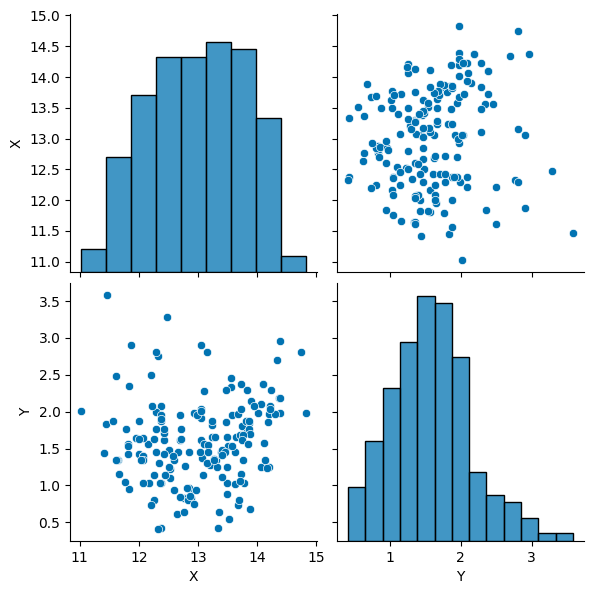

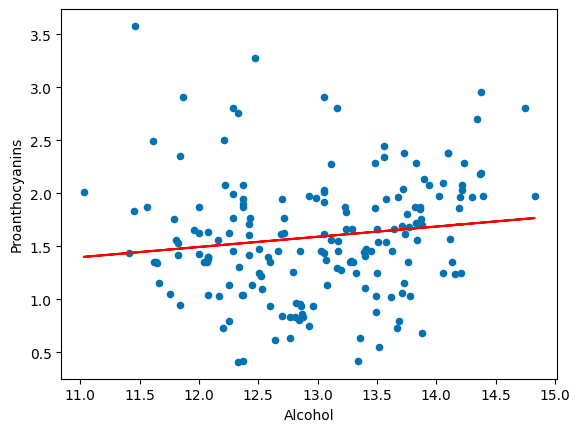

{'Lagrange Multiplier statistic:': 3.3118102210665907, "LM test's p-value:": 0.19091917452310858, 'F-statistic:': 1.6588608234480304, "F-test's p-value:": 0.1933347567333489}
Feature Proanthocyanins makes regression model homoscedastic
===== Feature: Color_intensity
lr.coef_: [[1.56022048]]
lr.intercept_: [-15.2257406]
results.params: const     -15.225741
Alcohol     1.560220
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:        Color_intensity   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     74.90
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           3.06e-15
Time:                        14:08:50   Log-Likelihood:                -370.18
No. Observations:                 178   AIC:                             744.4
Df Residuals:                     17

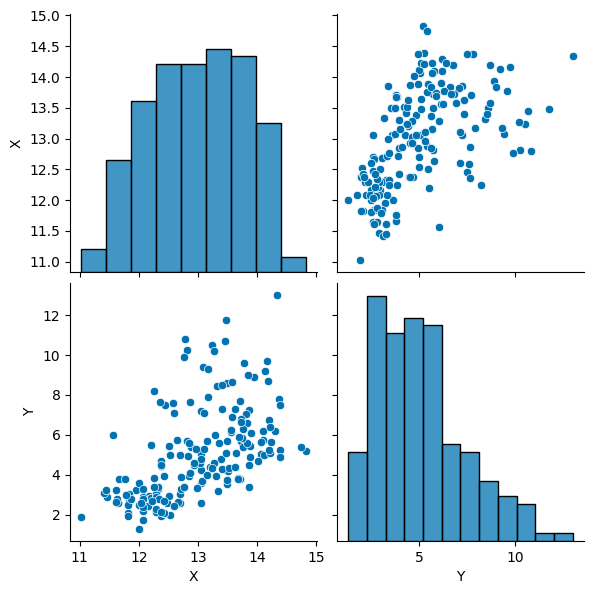

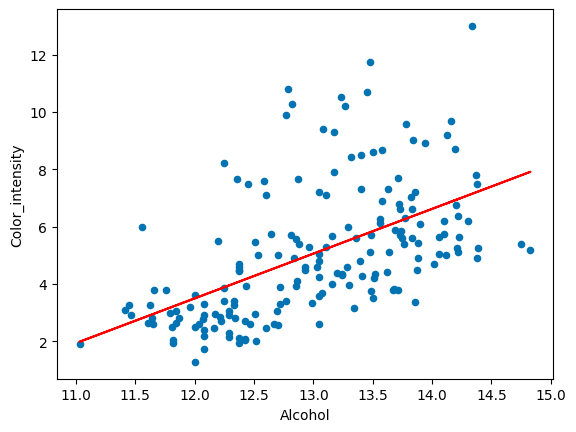

{'Lagrange Multiplier statistic:': 5.391450827921087, "LM test's p-value:": 0.06749340335451966, 'F-statistic:': 2.733074055172031, "F-test's p-value:": 0.06779555802825442}
Feature Color_intensity makes regression model homoscedastic
===== Feature: Hue
lr.coef_: [[-0.02020058]]
lr.intercept_: [1.2200695]
results.params: const      1.220069
Alcohol   -0.020201
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:                    Hue   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9107
Date:                Wed, 10 Jan 2024   Prob (F-statistic):              0.341
Time:                        14:08:51   Log-Likelihood:                 11.101
No. Observations:                 178   AIC:                            -18.20
Df Residuals:                     176   BIC:        

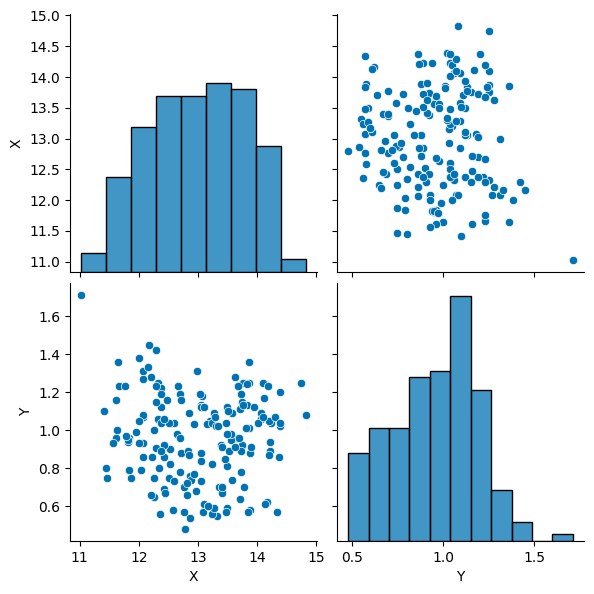

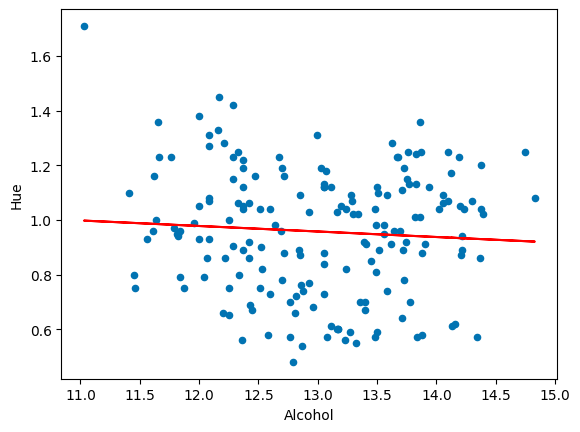

{'Lagrange Multiplier statistic:': 3.415562911269416, "LM test's p-value:": 0.18126749683675975, 'F-statistic:': 1.711846483682739, "F-test's p-value:": 0.18354113223148794}
Feature Hue makes regression model homoscedastic
===== Feature: 0D280_0D315_of_diluted_wines
lr.coef_: [[0.06326841]]
lr.intercept_: [1.78915702]
results.params: const      1.789157
Alcohol    0.063268
dtype: float64
results.summary:                                  OLS Regression Results                                 
Dep. Variable:     0D280_0D315_of_diluted_wines   R-squared:                       0.005
Model:                                      OLS   Adj. R-squared:                 -0.000
Method:                           Least Squares   F-statistic:                    0.9259
Date:                          Wed, 10 Jan 2024   Prob (F-statistic):              0.337
Time:                                  14:08:51   Log-Likelihood:                -190.64
No. Observations:                           178   AIC:    

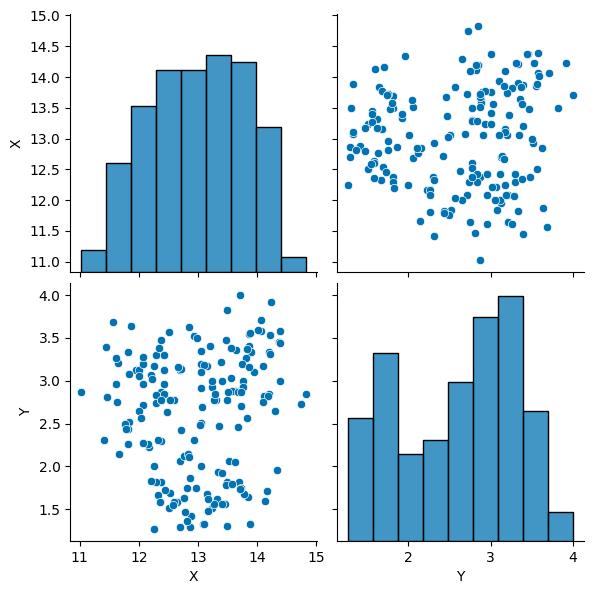

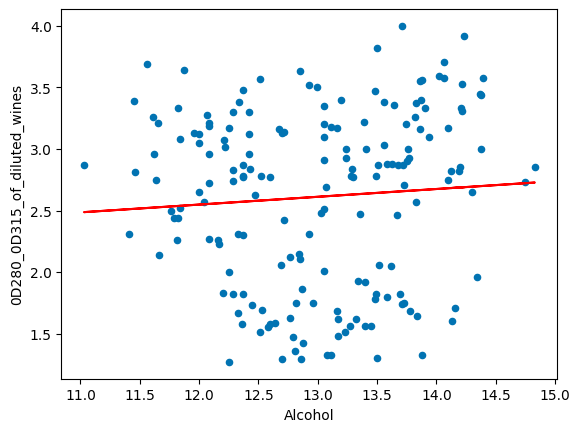

{'Lagrange Multiplier statistic:': 8.046110940716048, "LM test's p-value:": 0.01789819390553833, 'F-statistic:': 4.142504247531935, "F-test's p-value:": 0.017467134358600117}
Feature 0D280_0D315_of_diluted_wines makes regression model heteroscedastic
===== Feature: Proline
lr.coef_: [[249.69897085]]
lr.intercept_: [-2499.34767098]
results.params: const     -2499.347671
Alcohol     249.698971
dtype: float64
results.summary:                             OLS Regression Results                            
Dep. Variable:                Proline   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     124.5
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           3.29e-22
Time:                        14:08:52   Log-Likelihood:                -1228.4
No. Observations:                 178   AIC:                             2461.
Df Residuals:       

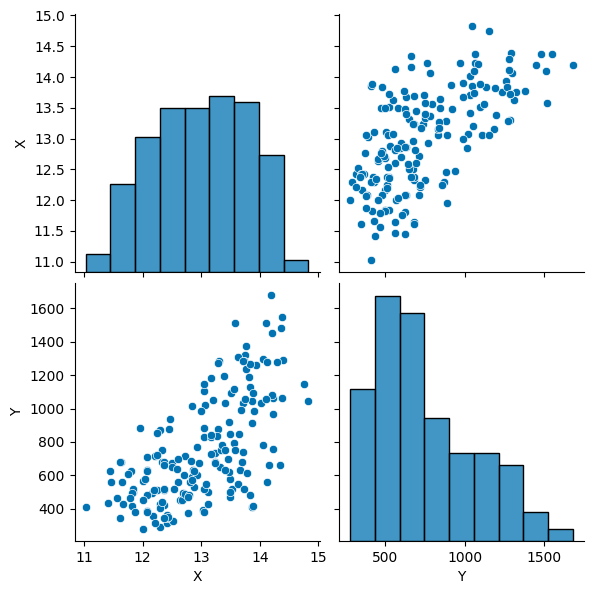

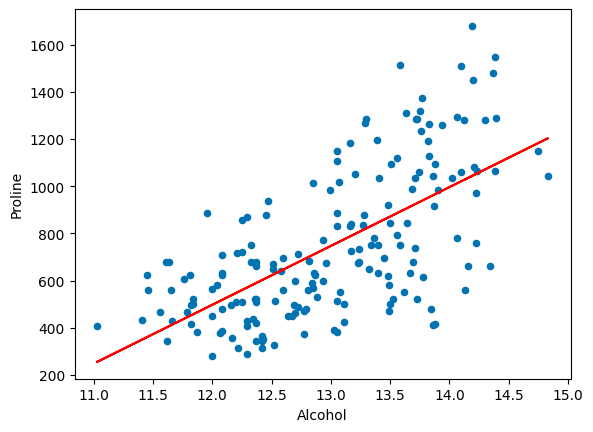

{'Lagrange Multiplier statistic:': 22.728664057171624, "LM test's p-value:": 1.160201197715209e-05, 'F-statistic:': 12.808275867058857, "F-test's p-value:": 6.437802408219705e-06}
Feature Proline makes regression model heteroscedastic


In [18]:
for feature in X_all_features.columns[1 :]:
    print(f"===== Feature: {feature}")

    X2, y2, data2 = create_dataset(X_all_features, y, 'Alcohol', feature)
    visualize_dataset(data2)
    lr2 = apply_linear_regression(X2, y2)
    results2 = ols_lr(X2, y2)

    plot_lr(X2, data2, lr2, 'Alcohol', feature)

    final_results = white_test(data2, results2)
    if final_results["LM test's p-value:"] > 0.05:
        print(f"Feature {feature} makes regression model homoscedastic")
    else:
        print(f"Feature {feature} makes regression model heteroscedastic")


#### Let's choose as feature that makes the model heteroscedastic and try to solve it!

lr.coef_: [[0.06326841]]
lr.intercept_: [1.78915702]
results.params: const      1.789157
Alcohol    0.063268
dtype: float64
results.summary:                                  OLS Regression Results                                 
Dep. Variable:     0D280_0D315_of_diluted_wines   R-squared:                       0.005
Model:                                      OLS   Adj. R-squared:                 -0.000
Method:                           Least Squares   F-statistic:                    0.9259
Date:                          Wed, 10 Jan 2024   Prob (F-statistic):              0.337
Time:                                  14:08:53   Log-Likelihood:                -190.64
No. Observations:                           178   AIC:                             385.3
Df Residuals:                               176   BIC:                             391.6
Df Model:                                     1                                         
Covariance Type:                      nonrobust           

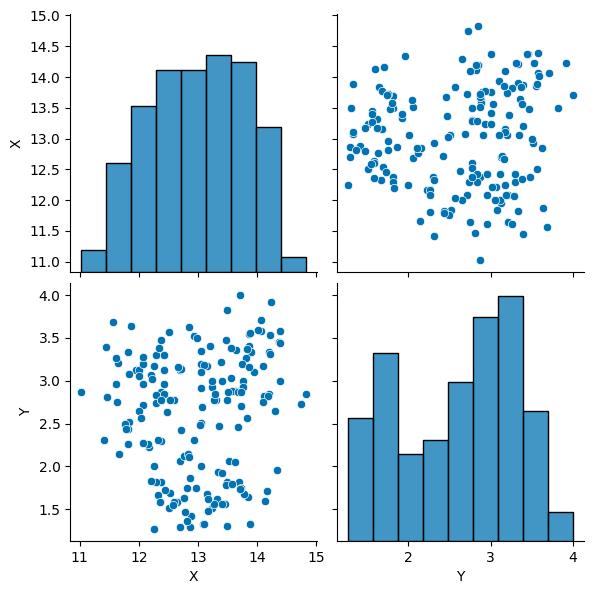

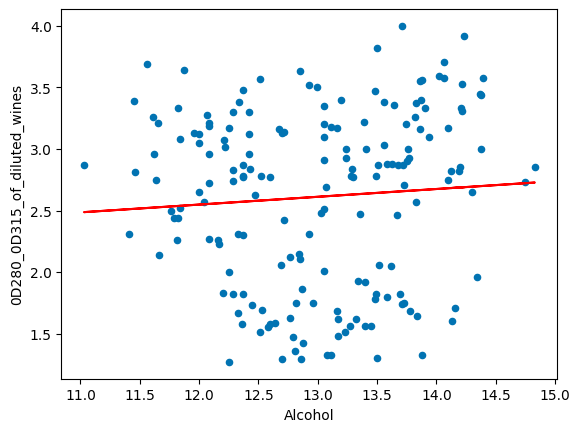

{'Lagrange Multiplier statistic:': 8.046110940716048, "LM test's p-value:": 0.01789819390553833, 'F-statistic:': 4.142504247531935, "F-test's p-value:": 0.017467134358600117}
Feature Proline makes regression model heteroscedastic


In [19]:
# Keep only one feature
X_hetero, y_hetero, data_hetero = create_dataset(X_all_features, y, 'Alcohol', '0D280_0D315_of_diluted_wines')
visualize_dataset(data_hetero)
lr_hetero = apply_linear_regression(X_hetero, y_hetero)
results_hetero = ols_lr(X_hetero, y_hetero)

plot_lr(X_hetero, data_hetero, lr_hetero, 'Alcohol', '0D280_0D315_of_diluted_wines')

final_results = white_test(data_hetero, results_hetero)
if final_results["LM test's p-value:"] > 0.05:
    print(f"Feature {feature} makes regression model homoscedastic")
else:
    print(f"Feature {feature} makes regression model heteroscedastic")

##### Weighted Least Squares Regression to fix Heteroscedasticity

References: 
* https://www.statology.org/weighted-least-squares-in-python/

In [20]:
import statsmodels.formula.api as smf

In [21]:
ols_lr(X_hetero, y_hetero)

results.params: const      1.789157
Alcohol    0.063268
dtype: float64
results.summary:                                  OLS Regression Results                                 
Dep. Variable:     0D280_0D315_of_diluted_wines   R-squared:                       0.005
Model:                                      OLS   Adj. R-squared:                 -0.000
Method:                           Least Squares   F-statistic:                    0.9259
Date:                          Wed, 10 Jan 2024   Prob (F-statistic):              0.337
Time:                                  14:08:54   Log-Likelihood:                -190.64
No. Observations:                           178   AIC:                             385.3
Df Residuals:                               176   BIC:                             391.6
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef 

In [22]:
def plot_fitted_values(X, y, lr, fit_wls, x_feature, y_feature):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

    fitted_values = fit_wls.fittedvalues
    y = fit_wls.model.endog

    ax1.scatter(x=X, y=y)
    ax1.plot(X, lr.predict(X), color='red')
    ax1.set_title('Regression Plot')

    ax2.scatter(x=X, y=y)
    ax2.plot(X, fitted_values, color='red')
    ax2.set_title('Regression Plot for WLS Regression Model')

    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

                                 WLS Regression Results                                 
Dep. Variable:     0D280_0D315_of_diluted_wines   R-squared:                       0.001
Model:                                      WLS   Adj. R-squared:                 -0.004
Method:                           Least Squares   F-statistic:                    0.2307
Date:                          Wed, 10 Jan 2024   Prob (F-statistic):              0.632
Time:                                  14:08:54   Log-Likelihood:                -189.86
No. Observations:                           178   AIC:                             383.7
Df Residuals:                               176   BIC:                             390.1
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

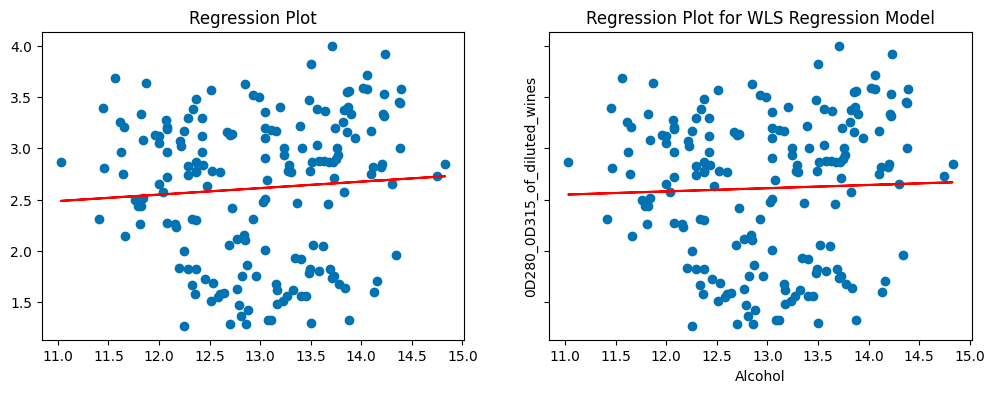

In [23]:
dataset_hetero = sm.add_constant(X_hetero)
wt = 1 / smf.ols('results_hetero.resid.abs() ~ results_hetero.fittedvalues', data=dataset_hetero).fit().fittedvalues**2
fit_wls = sm.WLS(y_hetero, dataset_hetero, weights=wt).fit()
print(fit_wls.summary())

plot_fitted_values(X_hetero, y_hetero, lr_hetero, fit_wls, 'Alcohol', '0D280_0D315_of_diluted_wines')